In [2]:
import pandas as pd
import sys
sys.path.append("../src")

from fpl.pipelines.optimization.data_classes import GwResults
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import sqlite3

In [3]:
with sqlite3.connect("../data/fpl.db") as conn:
    raw_data = pd.read_sql(f"select * from inference_results", conn)
display(raw_data.head())

,index,season,fpl_name,date,player,minutes,team,opponent,venue,pos,...,home_total_def_elo_ma5,away_total_def_elo_ma5,match_points_ma5,league_points_ma5,fpl_points,experiment_id,start_time,prediction,prediction_error,fpl_points_ma5_error
0,166813,2023-2024,Ameen Al-Dakhil,2023-08-11 00:00:00.000000,Ameen Al-Dakhil,90.0,Burnley,Manchester City,Home,CB,...,1.711274,2.377949,1.36,1.36,1.0,1161,20240824_121619,1.337672,0.337672,0.08
1,166814,2023-2024,Anass Zaroury,2023-08-11 00:00:00.000000,Anass Zaroury,30.0,Burnley,Manchester City,Home,FW,...,1.768046,2.271162,0.84,1.20,-2.0,1161,20240824_121619,1.553364,3.553364,3.88
2,166815,2023-2024,Arijanet Muric,2023-08-11 00:00:00.000000,None,0.0,Burnley,Manchester City,Home,GK,...,1.868068,2.297224,1.40,1.28,0.0,1161,20240824_121619,2.510879,2.510879,3.68
3,166849,2023-2024,Aymeric Laporte,2023-08-11 00:00:00.000000,Aymeric Laporte,11.0,Manchester City,Burnley,Away,CB,...,1.160272,1.502992,2.40,2.60,1.0,1161,20240824_121619,3.536463,2.536463,2.80
4,166816,2023-2024,Bailey Peacock-Farrell,2023-08-11 00:00:00.000000,None,0.0,Burnley,Manchester City,Home,GK,...,1.694874,2.223422,1.20,1.12,0.0,1161,20240824_121619,2.491028,2.491028,3.20


set()
{2, 3, 4, 5, 6, 7, 8}
{32, 33, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38}
{29, 35, 5}
{25, 29, 35, 5}


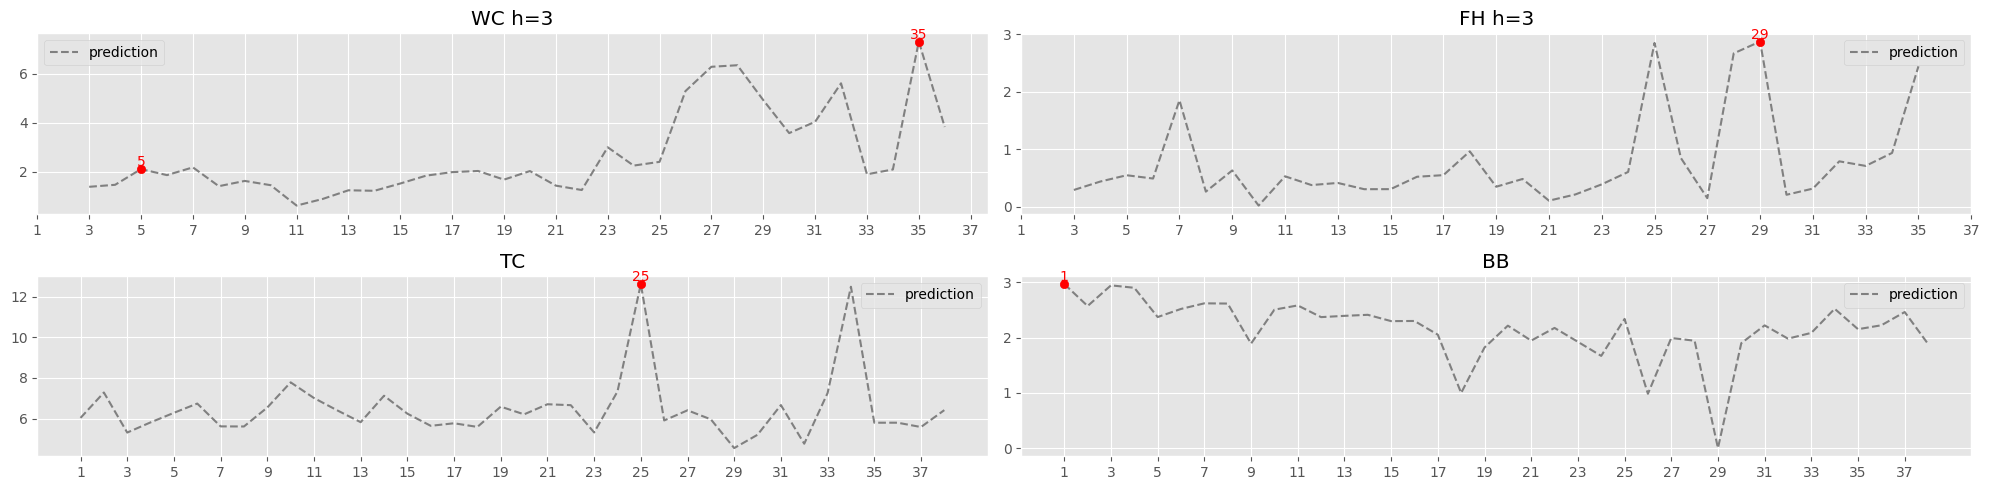

set()
{15, 16, 17, 18, 19, 20, 21}
{15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}
{24, 33, 18}
{24, 33, 18, 7}


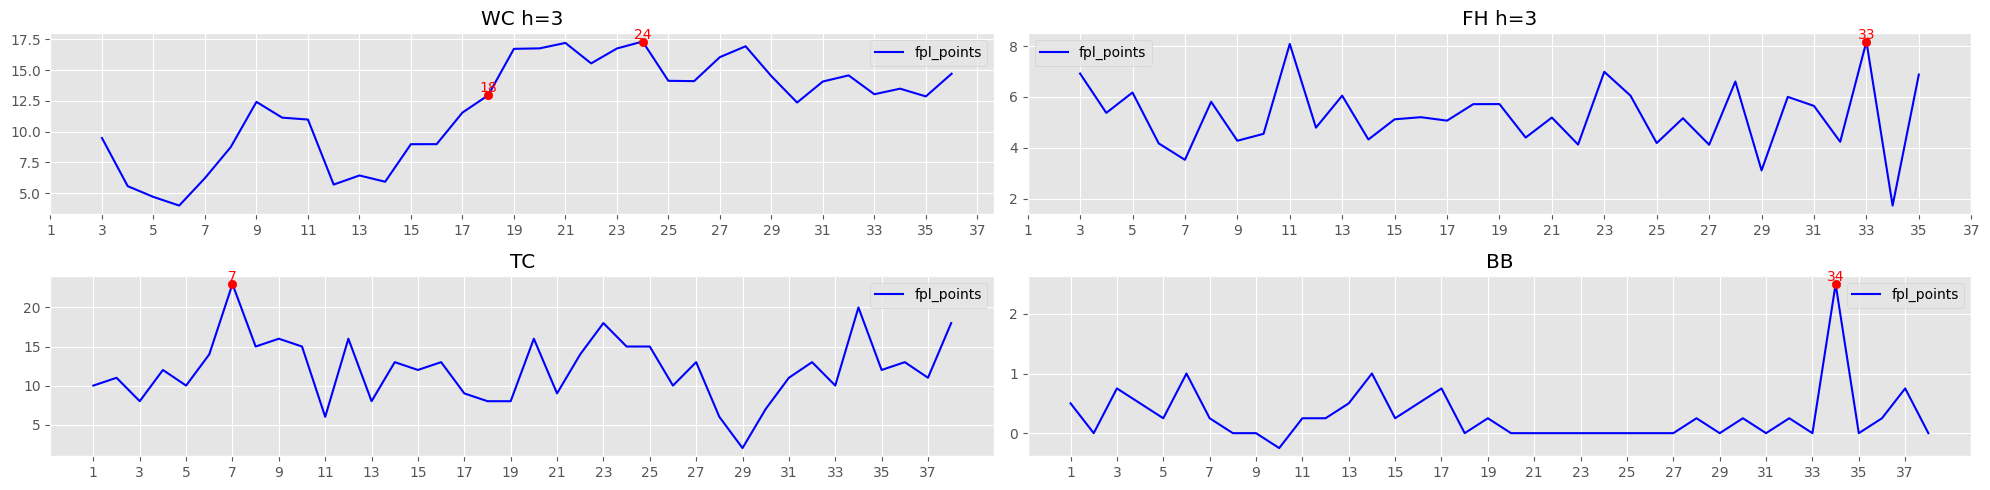

In [28]:
def aggregate_points_data(data, column):
    points = (
        data.loc[data["season"] == season].groupby(["fpl_name", "round"])[column].sum()
    )
    all_players = points.index.get_level_values("fpl_name").unique()
    all_rounds = points.index.get_level_values("round").unique()
    all_combinations = (
        pd.MultiIndex.from_product(
            [all_players, all_rounds], names=["fpl_name", "round"]
        )
        .to_frame()
        .set_index(["fpl_name", "round"])
    )
    points = (
        pd.merge(
            all_combinations, points, how="left", left_index=True, right_index=True
        )
        .reset_index()
        .fillna(0)
    )
    points["round"] = points["round"].astype(int)
    points = points.sort_values(["fpl_name", "round"])
    points = (
        data.loc[data["season"] == season].groupby(["fpl_name", "round"])[column].sum()
    )
    all_players = points.index.get_level_values("fpl_name").unique()
    all_rounds = points.index.get_level_values("round").unique()
    all_combinations = (
        pd.MultiIndex.from_product(
            [all_players, all_rounds], names=["fpl_name", "round"]
        )
        .to_frame()
        .set_index(["fpl_name", "round"])
    )
    points = (
        pd.merge(
            all_combinations, points, how="left", left_index=True, right_index=True
        )
        .reset_index()
        .fillna(0)
    )
    points["round"] = points["round"].astype(int)
    return points.sort_values(["fpl_name", "round"])


def find_top_players(points, column):
    top_players = points.groupby("round").apply(
        lambda x: x[x[column] >= x[column].quantile(0.95)]
    )
    return top_players.index.levels[1]


def avg_points_gained(points, squad, prev_points_col, next_points_col):
    if len(squad) > 0:
        selected = points["fpl_name"].isin(squad)
    else:
        selected = find_top_players(points, prev_points_col)

    top_unselected = find_top_players(points, next_points_col)

    points.loc[selected, "avoided_loss"] = (
        points.loc[selected, prev_points_col] - points.loc[selected, next_points_col]
    )
    points.loc[top_unselected, "captured_gain"] = (
        points.loc[top_unselected, next_points_col]
        - points.loc[top_unselected, prev_points_col]
    )
    average_gain = points.groupby("round")["captured_gain"].mean()
    average_loss = points.groupby("round")["avoided_loss"].mean()
    return average_gain + average_loss


def find_step_gains(points, horizon, column, squad):
    points["prev_n_gw_sum"] = points.groupby("fpl_name")[column].transform(
        lambda x: x.shift(1).rolling(horizon, min_periods=1).sum()
    )
    points["next_n_gw_sum"] = points.groupby("fpl_name")[column].transform(
        lambda x: x.iloc[::-1].rolling(horizon, min_periods=1).sum().iloc[::-1]
    )
    total_gains = avg_points_gained(points, squad, "prev_n_gw_sum", "next_n_gw_sum")
    return total_gains


def get_excluded_weeks(chips_usage, expanded):
    excluded = set()
    for chip, week in chips_usage.items():
        if week is None:
            continue
        if chip in ("wildcard1", "wildcard2", "free_hit") and expanded:
            for w in range(week - 3, week + 3 + 1):
                excluded.add(w)
        else:
            excluded.add(week)
    print(excluded)
    return excluded


def suggest_wildcard_weeks(points, squad, column, horizon, current_week, chips_usage):
    points = aggregate_points_data(inference_results, column)
    wc1_deadline = 19

    before_wc = find_step_gains(points, horizon, column, squad)
    if current_week <= wc1_deadline:
        excluded = get_excluded_weeks(chips_usage, expanded=True)
        candidates = before_wc.loc[:wc1_deadline]
        candidates = candidates.loc[~candidates.index.isin(excluded)]
        chips_usage["wildcard1"] = candidates.idxmax()
        before_wc = before_wc.loc[: chips_usage["wildcard1"]]
    else:
        chips_usage["wildcard2"] = before_wc.loc[wc1_deadline + 1 :].idxmax()
        before_wc = before_wc.loc[: chips_usage["wildcard2"]]
    after_wc = find_step_gains(points, horizon, column, [])
    if current_week <= wc1_deadline:
        after_wc = after_wc.loc[chips_usage["wildcard1"] + 1 :]
        excluded = get_excluded_weeks(chips_usage, expanded=True)
        candidates = after_wc.loc[wc1_deadline + 1 :]
        candidates = candidates.loc[~candidates.index.isin(excluded)]
        chips_usage["wildcard2"] = candidates.idxmax()
    else:
        after_wc = after_wc.loc[chips_usage["wildcard2"] + 1 :]
    fixture_swings = pd.concat([before_wc, after_wc]).loc[
        max(horizon, current_week) : 38 - horizon + 1
    ]
    return fixture_swings


def suggest_free_hit_week(
    inference_results, squad, column, horizon, current_week, chips_usage
):
    points = aggregate_points_data(inference_results, column)

    points["prev_n_gw_sum"] = points.groupby("fpl_name")[column].transform(
        lambda x: x.shift(1).rolling(horizon - 1).sum()
    )
    points["next_n_gw_sum"] = points.groupby("fpl_name")[column].transform(
        lambda x: x.iloc[::-1].rolling(horizon - 1).sum().iloc[::-1].shift(-1)
    )
    points["outside_avg"] = (
        (points["prev_n_gw_sum"] + points["next_n_gw_sum"]) / (horizon - 1) / 2
    )
    fixture_spikes = avg_points_gained(points, squad, "outside_avg", column)
    fixture_spikes = fixture_spikes.loc[max(horizon, current_week) : 38 - horizon]
    excluded = get_excluded_weeks(chips_usage, expanded=True)
    chips_usage["free_hit"] = fixture_spikes.loc[
        ~fixture_spikes.index.isin(excluded)
    ].idxmax()
    return fixture_spikes


def suggest_triple_captain_week(
    inference_results, squad, column, current_week, chips_usage
):
    points = aggregate_points_data(inference_results, column)
    if len(squad) > 0:
        points = points.loc[points["fpl_name"].isin(squad)]
    max_points = points.groupby("round")[column].max()
    max_points = max_points.loc[current_week:]
    excluded = get_excluded_weeks(chips_usage, expanded=False)
    chips_usage["triple_captain"] = max_points.loc[
        ~max_points.index.isin(excluded)
    ].idxmax()
    return max_points


def suggest_bench_boost_week(
    inference_results, squad, column, current_week, chips_usage
):
    points = aggregate_points_data(inference_results, column)
    if len(squad) > 0:
        points = points.loc[points["fpl_name"].isin(squad)]
        bench_players = points.groupby("round").apply(lambda x: x.nsmallest(4, column))
        bench_idx = bench_players.index.levels[1]
        points = points.loc[bench_idx]
    else:
        top_players = find_top_players(points, column)
        points = points.loc[~points.index.isin(top_players)]
    bench_points = points.groupby("round")[column].mean()
    bench_points = bench_points.loc[current_week:]
    excluded = get_excluded_weeks(chips_usage, expanded=False)
    chips_usage["bench_boost"] = bench_points.loc[
        ~bench_points.index.isin(excluded)
    ].idxmax()
    return bench_points


season = "2023-2024"
current_week = 1
inference_results = raw_data
squad = [
    "Gabriel Fernando de Jesus",
    "Martin Ødegaard",
    "Bukayo Saka",
    "David Raya Martin",
    "Ollie Watkins",
    "Ethan Pinnock",
    "Yoane Wissa",
    "Pervis Estupiñán",
    "Eberechi Eze",
    "Joel Ward",
    "Abdoulaye Doucouré",
    "Jordan Pickford",
    "James Tarkowski",
    "Trent Alexander-Arnold",
    "Mohamed Salah",
]
start_week = 1
styles = {
    "fpl_points": dict(color="blue", linestyle="-"),
    "prediction": dict(color="grey", linestyle="--"),
}

for col in ["prediction", "fpl_points"]:
    chips_usage = {
        "wildcard1": None,
        "wildcard2": None,
        "free_hit": None,
        "triple_captain": None,
        "bench_boost": None,
    }
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(
        2,
        2,
        figsize=(20, 5),
    )
    fixture_swings = suggest_wildcard_weeks(
        inference_results,
        squad,
        col,
        horizon=3,
        current_week=current_week,
        chips_usage=chips_usage,
    )
    ax0.plot(
        fixture_swings.index,
        fixture_swings.values,
        label=col,
        color=styles[col]["color"],
        linestyle=styles[col]["linestyle"],
    )
    ax0.scatter(
        chips_usage["wildcard1"],
        fixture_swings.loc[chips_usage["wildcard1"]],
        color="red",
        label="_nolegend_",
        zorder=5,
    )
    ax0.text(
        chips_usage["wildcard1"],
        fixture_swings.loc[chips_usage["wildcard1"]],
        chips_usage["wildcard1"],
        color="red",
        fontsize=10,
        ha="center",
        va="bottom",
    )
    ax0.scatter(
        chips_usage["wildcard2"],
        fixture_swings.loc[chips_usage["wildcard2"]],
        color="red",
        label="_nolegend_",
        zorder=5,
    )
    ax0.text(
        chips_usage["wildcard2"],
        fixture_swings.loc[chips_usage["wildcard2"]],
        chips_usage["wildcard2"],
        color="red",
        fontsize=10,
        ha="center",
        va="bottom",
    )

    ax0.set_title(f"WC h=3")
    ax0.grid(True)
    ax0.legend()
    ax0.set_xticks(range(1, 39, 2))

    fixture_spikes = suggest_free_hit_week(
        inference_results,
        squad,
        col,
        horizon=3,
        current_week=current_week,
        chips_usage=chips_usage,
    )
    ax1.plot(
        fixture_spikes.index,
        fixture_spikes.values,
        label=col,
        color=styles[col]["color"],
        linestyle=styles[col]["linestyle"],
    )
    ax1.scatter(
        chips_usage["free_hit"],
        fixture_spikes.loc[chips_usage["free_hit"]],
        color="red",
        label="_nolegend_",
        zorder=5,
    )
    ax1.text(
        chips_usage["free_hit"],
        fixture_spikes.loc[chips_usage["free_hit"]],
        chips_usage["free_hit"],
        color="red",
        fontsize=10,
        ha="center",
        va="bottom",
    )
    ax1.set_title(f"FH h=3")
    ax1.grid(True)
    ax1.legend()
    ax1.set_xticks(range(1, 39, 2))

    top_scores = suggest_triple_captain_week(
        inference_results,
        squad,
        col,
        current_week=current_week,
        chips_usage=chips_usage,
    )
    ax2.plot(
        top_scores.index,
        top_scores.values,
        label=col,
        color=styles[col]["color"],
        linestyle=styles[col]["linestyle"],
    )
    ax2.scatter(
        chips_usage["triple_captain"],
        top_scores.loc[chips_usage["triple_captain"]],
        color="red",
        label="_nolegend_",
        zorder=5,
    )
    ax2.text(
        chips_usage["triple_captain"],
        top_scores.loc[chips_usage["triple_captain"]],
        chips_usage["triple_captain"],
        color="red",
        fontsize=10,
        ha="center",
        va="bottom",
    )
    ax2.set_title("TC")
    ax2.grid(True)
    ax2.legend()
    ax2.set_xticks(range(1, 39, 2))

    bench_scores = suggest_bench_boost_week(
        inference_results,
        squad,
        col,
        current_week=current_week,
        chips_usage=chips_usage,
    )
    ax3.plot(
        bench_scores.index,
        bench_scores.values,
        label=col,
        color=styles[col]["color"],
        linestyle=styles[col]["linestyle"],
    )
    ax3.scatter(
        chips_usage["bench_boost"],
        bench_scores.loc[chips_usage["bench_boost"]],
        color="red",
        label="_nolegend_",
        zorder=5,
    )
    ax3.text(
        chips_usage["bench_boost"],
        bench_scores.loc[chips_usage["bench_boost"]],
        chips_usage["bench_boost"],
        color="red",
        fontsize=10,
        ha="center",
        va="bottom",
    )

    ax3.set_title("BB")
    ax3.grid(True)
    ax3.legend()
    ax3.set_xticks(range(1, 39, 2))

    plt.tight_layout()
    plt.show()